<a href="https://colab.research.google.com/github/yyyyyYvvvvV/Worldmodel2023_10/blob/Hirai/book/%E4%B8%96%E7%95%8C%E3%83%A2%E3%83%87%E3%83%AB_%E6%9C%80%E7%B5%82%E8%AA%B2%E9%A1%8C_ResVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install h5py

In [1]:
# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import platform
print(platform.python_version())

# インストールされているパッケージを表示する場合
!pip list

In [1]:
UTILS_DIR = "/content/drive/MyDrive/世界モデル/演習資料/第8回/"
# UTILS_DIR = "/workspace/"

In [2]:
# ライブラリのインポート
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import math
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import h5py
from tqdm import tqdm
import torchvision
from torch.utils.data import Dataset

from tqdm.notebook import tqdm
import inspect
import pickle
import pandas as pd

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
assert torch.cuda.is_available()
device = "cuda"

## 2.データセットの準備

In [4]:
class SyntheticDataset(Dataset):
    def __init__(self, split='train', n_steps=10, transform=None):
        """
        配布済みのVMDSデータセットを読み込み，Datasetクラスを初期化する．

        Parameters
        ----------
        split : str
            {'train', 'val', 'test}
        n_steps : int
            動画の最初の何フレームまでを使用するか
        transform : torchvision.transforms
            動画への前処理
        """
        self.transform = transform

        imgs = np.load(os.path.join(UTILS_DIR, "lecture08_utils", f"vmds_{split}.npy")) # ( samples, t, c, h, w )
        imgs = imgs[:, :n_steps] # ( samples, n_steps, c, h, w )

        self.imgs = [img for img in imgs]

    def __getitem__(self, index):
        """
        鉤括弧[]で要素にアクセスしたときに呼び出されるPythonの特殊メソッド
        ここで動画に対し前処理をする実装になっている．

        Parameters
        ----------
        index : int
            アクセスされた要素のインデックス

        Returns
        ----------
        x : torch.Tensor ( n_steps, c, h, w )
            データサンプル
        """
        x = self.imgs.__getitem__(index)

        if self.transform is not None:
            x = self.transform(x)

        return x

    def __len__(self):
        """ オブジェクトの長さを返す（ここではデータセットのサイズ）Pythonの特殊メソッド """
        return len(self.imgs)

In [5]:
def build_dataloader(batch_size, num_workers=1, n_steps=10):
    """
    訓練と検証用のデータローダーを作成する．

    Parameters
    ----------
    num_workers : int
        データローディングにいくつのサブプロセスを使うか
        num_workers=0ならデータローディングもメインプロセスで行われる．
    n_steps : int
        動画の最初の何フレームまでを使用するか
    dataset_class : str
    """
    kwargs = {'batch_size': batch_size, 'num_workers': num_workers, 'pin_memory': True}

    transform = torchvision.transforms.Lambda(lambda n: n / 255.)

    train_loader = torch.utils.data.DataLoader(
        SyntheticDataset(split='train', n_steps=n_steps, transform=transform),
        shuffle=True,
        **kwargs
    )
    val_loader = torch.utils.data.DataLoader(
        SyntheticDataset(split='val', n_steps=n_steps, transform=transform),
        shuffle=False,
        **kwargs
    )

    return train_loader, val_loader


def build_testloader(batch_size, num_workers=1, n_steps=10):
    """ テスト用のデータローダーを作成する． """
    kwargs = {'batch_size': batch_size, 'num_workers': num_workers, 'pin_memory': True}

    transform = torchvision.transforms.Lambda(lambda n: n / 255.)

    test_loader = torch.utils.data.DataLoader(
        SyntheticDataset(split='test', n_steps=n_steps, transform=transform),
        shuffle=True,
        **kwargs
    )

    return test_loader

In [6]:
def display_video(frames) -> None:
    """
    中身を動画でみるための関数

    Parameters
    ----------
    frames : List[torch.Tensor]
        可視化する動画
    """
    plt.figure(figsize=(8, 8), dpi=50)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        plt.title("Step %d" % (i))

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    display(HTML(anim.to_jshtml(default_mode='once')))
    plt.close()


config_path = os.path.join(UTILS_DIR, "lecture08_utils", "config.json")

config = json.load(open(config_path))

train_loader, val_loader = build_dataloader(
    batch_size= config['data']['batch_size'],
    num_workers=config['data']['num_workers'],
    n_steps=config['data']['n_steps'],
)

videos = next(iter(train_loader)) # ( batch_size, n_steps, c, h, w )

display_video(list(videos[1].permute(0, 2, 3, 1)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## モデルの構築

In [7]:
# class ConvEncoder(nn.Module):
#     def __init__(self, config):
#         super(ConvEncoder, self).__init__()
#         self.latent_dim = config['vae']['latent_dim']

#         self.g = nn.Sequential(
#             nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(inplace=True), # 少しメモリを節約できるオプション
#             nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Flatten(),
#             nn.Linear(1024, 256),
#             nn.ReLU(inplace=True),
#             nn.Linear(256, 2 * self.latent_dim)
#         )

#     def forward(self, x):
#         mu_logvar = self.g(x)
#         return mu_logvar


# class BroadcastConvDecoder(nn.Module):
#     def __init__(self, config):
#         super(BroadcastConvDecoder, self).__init__()
#         self.im_size = config['data']['im_size'] + 8
#         self.latent_dim = config['vae']['latent_dim']
#         self._init_grid()

#         self.h = nn.Sequential(
#             nn.Conv2d(self.latent_dim + 2, 32, kernel_size=3, stride=1, padding=0),
#             # nn.Conv2d(self.latent_dim + 2, self.latent_dim * 2, kernel_size=3, stride=1, padding=0),
#             nn.ReLU(True),
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
#             nn.ReLU(True),
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
#             nn.ReLU(True),
#             nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
#             nn.ReLU(True),
#             nn.Conv2d(32, 4, kernel_size=1, stride=1, padding=0)
#         )

#     def _init_grid(self):
#         x = torch.linspace(-1, 1, self.im_size)
#         y = torch.linspace(-1, 1, self.im_size)
#         self.x_grid, self.y_grid = torch.meshgrid(x, y)

#     def broadcast(self, z):
#         b = z.shape[0]
#         x_grid = self.x_grid.expand(b, 1, -1, -1).to(z.device)
#         y_grid = self.y_grid.expand(b, 1, -1, -1).to(z.device)
#         z_a = z.view((b, -1, 1, 1))
#         z_a = z_a.expand(-1, -1, self.im_size, self.im_size)
#         z_b = torch.cat((z_a, x_grid, y_grid), dim=1)
#         return z_b

#     def forward(self, z):
#         z_b = self.broadcast(z)
#         x = self.h(z_b)
#         x_k_mu = x[:, :3]
#         m_k_logits = x[:, 3:]
#         return x_k_mu, m_k_logits

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, in_ch, out_ch, resize=True, factor=2., skip=True):
        """
        U-Net各層にあるConvブロック

        Parameters
        ----------
        in_ch : int
            畳み込みの入力チャンネル数
        out_ch : int
            畳み込みの出力チャンネル数
        resize : bool
            Up-/ down-samplingを行うかどうか
        factor : float
            Up-/ down-samplingするときの倍率
        skip : bool
            順伝播でskip connection用のTensorを返すかどうか
        """
        super().__init__()

        self._resize = resize
        self._factor = factor
        self._skip = skip

        self.conv = nn.Conv2d(
            in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.inst_norm = nn.InstanceNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor ( b, c', h', w' )

        Returns
        ----------
        out : torch.Tensor ( b, c'', h'', w'' )
        skip : torch.Tensor ( b, c'', h', w' )
            Skip connection用のデコーダブロックに直接渡すTensor
        """
        x = self.conv(x)
        x = self.inst_norm(x)
        out = skip = self.relu(x)

        if self._resize:
            out = F.interpolate(out, scale_factor=self._factor, mode='nearest')

        if self._skip:
            return out, skip
        else:
            return out


class Encoder(nn.Module):
    def __init__(self, block, in_ch, out_ch):
        """
        Attention network (U-Net)のエンコーダ部分

        Parameters
        ----------
        block : AttentionBlock
        in_ch : List[int]
            各ブロックの入力チャンネル数
        out_ch : List[int]
            各ブロックの出力チャンネル数
        """
        super().__init__()
        assert len(out_ch) == len(in_ch)

        self.n_blocks = len(out_ch)
        self.blocks = nn.ModuleList()

        for i in range(self.n_blocks):
            resize = False if i == self.n_blocks -1 else True
            self.blocks.append(block(in_ch[i], out_ch[i], resize=resize, factor=.5))

    def forward(self, x):
        """
        n_blocks個のブロックに入力を通してdownsampling

        Parameters
        ----------
        x : torch.Tensor ( b, c + 2, im_size, im_size )
            入力画像x_t, 前ステップの予測マスク\hat{m}_{t,k}，スコープs_{t,k-1}を
            concatしたもの

        Returns
        ----------
        x : torch.Tensor ( b, c', h', w' )
        skips : List[torch.Tensor]
            Skip connection用のデコーダブロックに直接渡すTensor
        """
        skips = []
        for i in range(self.n_blocks):
            x, skip = self.blocks[i](x)
            skips.append(skip)

        return x, skips


class Decoder(nn.Module):
    def __init__(self, block, in_ch, out_ch):
        """
        Attention network (U-Net)のデコーダ部分

        Parameters
        ----------
        block : AttentionBlock
        in_ch : List[int]
            各ブロックの入力チャンネル数
        out_ch : List[int]
            各ブロックの出力チャンネル数
        """
        super().__init__()
        assert len(out_ch) == len(in_ch)

        self.n_blocks = len(out_ch)
        self.blocks = nn.ModuleList()
        for i in range(self.n_blocks):
            resize = False if i == self.n_blocks -1 else True
            self.blocks.append(block(in_ch[i], out_ch[i], resize=resize, factor=2., skip=False))

        # マスク画像はVAEへの入力として最終的に1チャンネルになる.
        self.conv = nn.Conv2d(
            out_ch[-1], 1, kernel_size=1, stride=1, padding=0, bias=False
        )

    def forward(self, x, skips):
        """
        n_blocks個のブロックに入力を通してupsampling

        Parameters
        ----------
        x : torch.Tensor ( b, c', h', w' )
            エンコーダとボトルネック部のMLPを通ってきた表現
        skips : List[torch.Tensor]
            Skip connection

        Returns
        ----------
        x : torch.Tensor ( b, 1, im_size, im_size )
            現在ステップのマスクm_{t,k}
        """
        for i in range(self.n_blocks):
            # skipsからLIFOで取っていく
            x = torch.cat([x, skips[-(i+1)]], dim=1)
            x = self.blocks[i](x)

        x = self.conv(x)

        return x

class AttentionModule(nn.Module):
    def __init__(self, encoder, decoder, in_ch=5, mlp_ch=256, n_sp=4):
        """
        エンコーダとデコーダからU-Netを構成する．

        Parameters
        ----------
        encoder : Encoder
        decoder : Decoder
        in_ch : int
            入力チャンネル数．入力画像（3チャンネル），前ステップの予測マスク（1チャンネル），
            スコープ（1チャンネル）がconcatされるので5
        mlp_ch : int
            ボトルネック部のMLPを通った後のチャンネル数
        n_sp : int
            デコーダ入力のサイズ
        """
        super().__init__()

        self.in_ch = in_ch
        self.mlp_ch = mlp_ch
        self.n_sp = n_sp
        n_ch = mlp_ch * n_sp * n_sp

        self.encoder = encoder
        self.decoder = decoder

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_ch, 128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Linear(128, n_ch),
            nn.ReLU(True),
        )

    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor ( b, in_ch (= c + 2), im_size, im_size )
            入力画像x_t, 前ステップの予測マスク\hat{m}_{t,k}，スコープs_{t,k-1}を
            concatしたもの

        Returns
        ----------
        x : torch.Tensor ( b, 1, im_size, im_size )
            現在ステップのマスクm_{t,k}
        """
        assert x.shape[1] == self.in_ch

        x, skips = self.encoder(x)

        x = self.mlp(x)
        x = x.view(-1, self.mlp_ch, self.n_sp, self.n_sp)

        x = self.decoder(x, skips)
        return x


def create_attn_model(in_ch=5):
    """ U-Netによるattention networkの構築 """
    encoder = Encoder(AttentionBlock, [in_ch, 32, 32, 32, 32], [32, 32, 32, 32, 32])
    decoder = Decoder(AttentionBlock, [64, 64, 64, 64, 64], [32, 32, 32, 32, 32])

    model = AttentionModule(encoder, decoder, in_ch, mlp_ch=32, n_sp=4)
    return model

In [9]:
class ViMON(nn.Module):
    def __init__(self, config, attn_module, vae_encoder, vae_decoder, inference=False) -> None:
        super(ViMON, self).__init__()

        self.inference = inference
        self.attn_module = attn_module

        self.n_slots = config['model']['n_slots']
        self.n_steps = config['data']['n_steps'] if inference else config['data']['n_steps'] - 1
        self.latent_dim = config['vae']['latent_dim']
        self.gru_dim = config['gru']['latent_dim']

        # 混合ガウス分布のそれぞれの標準偏差はあらかじめ決めて固定．最初のスロットは背景と対応づけ，小さくしておく．
        self.sigma = torch.cat(
            [torch.Tensor([0.09]), torch.Tensor([0.11]).repeat(self.n_slots - 1)]
        )[None, :, None, None, None] # ( 1, n_slots, 1, 1, 1 )

        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.criterion_kl = nn.KLDivLoss(reduction='batchmean')

        self.gru = nn.GRU(self.latent_dim * 2, self.gru_dim, batch_first=True)
        self.mlp = nn.Linear(self.gru_dim, 2 * self.latent_dim)
        self.linear = nn.Linear(self.latent_dim, self.latent_dim)  # 次ステップの潜在変数\hat{z}_{t+1,k}の予測用
        self.vae_encoder = vae_encoder
        self.vae_decoder = vae_decoder
        # self.deeplabv3_decoder = DeepLabV3Decoder(config)

        self._init_weights()

    def _init_weights(self) -> None:
        """ GRU，線形層の重みの初期化 """
        self.gru.bias_hh_l0.data.fill_(0)
        self.gru.bias_ih_l0.data.fill_(0)
        self.gru.weight_hh_l0.data.normal_(0, 1e-3)
        rand = torch.randn(3 * self.gru_dim, 2 * self.latent_dim) * 1e-3
        eye = rand + torch.cat(
            [torch.zeros(2 * self.gru_dim, 2 * self.latent_dim), torch.eye(self.gru_dim)[:, :2 * self.latent_dim]]
        )
        self.gru.weight_ih_l0.data.copy_(eye)

        self.mlp.apply(self._init_eye)
        self.linear.apply(self._init_eye)

    def _init_eye(self, m) -> None:
        if type(m) == nn.Linear:
            m.bias.data.fill_(0)
            torch.nn.init.eye_(m.weight)

    def reparameterize(self, mu, logvar):
        """
        VAEの再パラメータ化トリック

        Parameters
        ----------
        mu : torch.Tensor ( b, latent_dim )
            ガウス分布の平均
        logvar : torch.Tensor ( b, latent_dim )
            ガウス分布の分散の対数

        Returns
        ----------
        z_tk : torch.Tensor ( b, latent_dim )
            微分可能な形でガウス分布からサンプリングした値
        """
        if self.inference:
            return mu
        else:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)

            return mu + eps * std

    @staticmethod
    def gauss_prob(preds, targets, sigma):
        """
        ガウス分布の尤度の定義

        Parameters
        ----------
        preds : torch.Tensor ( b, n_steps or n_steps - 1, n_slots, c, h, w )
            x
        targets : torch.Tensor ( b, n_steps or n_steps - 1, 1, c, h, w )
            mu
        sigma : torch.Tensor ( 1, n_slots, 1, 1, 1 )
            標準偏差

        Returns
        ----------
        prob : torch.Tensor ( b, n_steps or n_steps - 1, n_slots, c, h, w )
        """
        return torch.exp(-torch.pow(preds - targets, 2) / (2 * torch.pow(sigma, 2))) / torch.sqrt(2 * sigma**2 * math.pi)

    @staticmethod
    def kl_div(mu, logvar):
        """
        ガウス分布（平均mu，分散var）と単位ガウス分布（平均0，分散I）のKLダイバージェンスの定義
        https://leenashekhar.github.io/2019-01-30-KL-Divergence/ の最後などを参照

        Parameters
        ----------
        mu : torch.Tensor ( b, n_steps, n_slots, latent_dim )
            事後分布の平均
        logvar : torch.Tensor ( b, n_steps, n_slots, latent_dim )
            事後分布の（対数）分散

        Returns
        ----------
        kl_loss : torch.Tensor (, )
        """
        return - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=3).mean(dim=(0, 1)).sum()

    def decoder_loglikelihood(self, target, slot_recon, mask_recon):
        """
        デコーダの尤度（混合ガウス分布）の定義

        Parameters
        ----------
        target : torch.Tensor ( b, n_steps or n_steps - 1, 1, c, h, w )
            入力動画 x_{1:T}の対応する部分
        slot_recon : torch.Tensor ( b, n_steps or n_steps - 1, n_slots, c, h, w )
            VAE Decoderの出力（全スロット）
        mask_recon : torch.Tensor ( b, n_steps or n_steps - 1, n_slots, 1, h, w )

        Returns
        ----------
        recon_loss : torch.Tensor (, )
            x_tの再構成誤差またはx_{t+1}の生成誤差
        """
        b, T, _, _, _, _ = target.size()

        # 混合ガウス分布の混合率
        mask_recon = F.softmax(mask_recon, dim=2)
        # それぞれのガウス分布の尤度（再構成誤差）
        x_prob = self.gauss_prob(slot_recon, target, self.sigma.to(slot_recon.device)) # WRITE ME
        # ( b, n_steps or n_steps - 1, n_slots, c, h, w )

        # 混合ガウス分布の尤度
        masked_x_prob = torch.sum(mask_recon * x_prob, dim=2) # WRITE ME
        # ( b, n_steps or n_steps - 1, c, h, w )
        masked_x_prob = torch.clamp(masked_x_prob, min=1e-5) # 最小値を1e-5にする．

        return - torch.log(masked_x_prob).sum() / (b * T)

    def accumulate_losses(self, target, curr_slots, curr_masks, next_slots, next_masks, attn_masks):
        """
        誤差の計算（目的関数第1,3項）

        Parameters
        ----------
        target : torch.Tensor ( b, T, c, h, w )
            入力動画 x_{1:T}
        curr_slots : torch.Tensor ( b, n_steps(= T - 1), n_slots, c, h, w )
            VAE Decoderの出力 \hat{x}_t
        curr_masks : torch.Tensor ( b, n_steps(= T - 1), n_slots, 1, h, w )
            VAE Decoderの出力 \hat{m}_t
        next_slots : torch.Tensor ( b, n_steps(= T - 1), n_slots, c, h, w )
            VAE Decoderの出力 \hat{x}_{t+1}
        next_masks : torch.Tensor ( b, n_steps(= T - 1), n_slots, 1, h, w )
            VAE Decoderの出力 \hat{m}_{t+1}
        attn_masks : torch.Tensor ( b, n_steps(= T - 1), n_slots, 1, h, w )
            Attention networkの出力 m_{t,k}

        Returns
        ----------
        losses : Dict[str, torch.Tensor]
        """
        b, T, _, _, _ = target.size()

        # -------------------------
        # 負の対数尤度（L_{negLL}）
        # -------------------------
        # x_tの再構成誤差
        recon_loss = self.decoder_loglikelihood(
            target[:, :-1, None, ...], curr_slots, curr_masks
        )# WRITE ME

        # x_{t+1}の生成誤差
        pred_loss = self.decoder_loglikelihood(
            target[:, 2:, None, ...], next_slots[:, 1:], next_masks[:, 1:]
        )

        # -------------------------------------
        # マスクのKLダイバージェンス（L_{mask}）
        # -------------------------------------
        # 推論（m_{t,k}）
        curr_mask_loss = self.criterion_kl(curr_masks.log_softmax(dim=2), attn_masks) / (T - 1)# WRITE ME

        # 次ステップの推論（m_{t+1,k}）
        next_mask_loss = self.criterion_kl(
            next_masks.log_softmax(dim=2)[:, 1:-1], attn_masks[:, 2:]
        ) / (T - 2)

        losses = {
            'recon_loss': recon_loss,
            'pred_loss': pred_loss,
            'curr_mask_loss': curr_mask_loss,
            'next_mask_loss': next_mask_loss
        }
        return losses


    def forward(self, x):
        """
        Parameters
        ----------
        x : torch.Tensor ( b, T, c, h, w )

        Returns
        ----------
        results : Dict[str, torch.Tensor]
            再構成された動画，マスクなどの結果
        losses : Dict[str, torch.Tensor]
        """
        b, _, c, h, w = x.size()

        # 空のtensor作成

        # Attention networkの出力マスクを保持
        attn_log_masks = torch.empty((b, self.n_steps, self.n_slots, 1, h, w), dtype=torch.float, device=x.device)

        # ステップtのマスク予測\hat{m}_tを保持
        curr_masks = torch.empty((b, self.n_steps, self.n_slots, 1, h, w), dtype=torch.float, device=x.device)
        # ステップtの再構成画像\hat{x}_tを保持
        curr_slots = torch.empty((b, self.n_steps, self.n_slots, 3, h, w), dtype=torch.float, device=x.device)

        # ステップt+1のマスク予測\hat{m}_{t+1}を保持
        next_masks = torch.empty((b, self.n_steps, self.n_slots, 1, h, w), dtype=torch.float, device=x.device)
        # ステップt+1の画像予測\hat{x}_{t+1}を保持
        next_slots = torch.empty((b, self.n_steps, self.n_slots, 3, h, w), dtype=torch.float, device=x.device)

        # ステップtのVAE潜在変数z'_{t,k}を保持
        mu = torch.empty((b, self.n_steps, self.n_slots, self.latent_dim), dtype=torch.float, device=x.device)
        logvar = torch.empty((b, self.n_steps, self.n_slots, self.latent_dim), dtype=torch.float, device=x.device)

        prev_hidden = torch.zeros((self.n_slots, 1, b, self.gru_dim), dtype=torch.float, device=x.device)
        # ステップt-1のマスク
        prev_masks = torch.zeros((b, self.n_slots, 1, h, w), dtype=torch.float, device=x.device)

        # タイムステップ分
        for t in range(self.n_steps):
            log_s_k = torch.zeros((b, 1, h, w), dtype=torch.float, device=x.device)
            hidden = []
            masks = []

            if t != 0:
                prev_masks = self.logsoftmax(prev_masks)

            # スロット分（対象物体分）ループ
            for k in range(self.n_slots):               ###############  tqdm  #######################
                # -----------------------------
                # ①にあたる部分 - マスクの推論
                # -----------------------------
                if k != self.n_slots - 1:
                    # Attention networkへの入力：現在フレーム画像，スコープ，前ステップのマスク予測
                    input_attn = torch.cat([x[:, t], log_s_k, prev_masks[:, k]], dim=1) # ( b, c + 2, h, w )

                    alpha_k = self.attn_module(input_attn) # ( b, 1, h, w )

                    # アテンションマスクの計算
                    log_m_k = log_s_k + F.logsigmoid(alpha_k)
                    # スコープの計算
                    log_s_k = log_s_k + F.logsigmoid(-alpha_k)
                else:
                    # 最後のスロットについてはフレームのこれまでに処理されていない部分とする．
                    log_m_k = log_s_k

                # -----------------------------
                #  ②にあたる部分 - update GRU
                # -----------------------------
                # VAE Encoderにx_tとm_{t,k}をconcatして入力
                input_enc = torch.cat([x[:, t], log_m_k], dim=1)  # ( b, c + 1, h, w )
                z_k = self.vae_encoder(input_enc)  # ( b, latent_dim * 2 )

                # 潜在変数を入力しGRUの状態を更新
                z_ = z_k[:, None, :] / 5.  # ( b, 1, latent_dim * 2 )
                # NOTE: batch_firstはhidden / cell statesには当てはまらない．
                out_gru_k, hidden_k = self.gru(z_, prev_hidden[k].contiguous())  # ( b, 1, gru_dim ), ( 1, b, gru_dim )
                out_gru_k_ = out_gru_k * 5.

                # VAEの潜在変数（z_{t,k}）に再変換
                out_k = self.mlp(out_gru_k_)  # ( b, 1, latent_dim * 2 )

                mu[:, t, k] = out_k[:, 0, :self.latent_dim]  # ( b, latent_dim )
                logvar[:, t, k] = out_k[:, 0, self.latent_dim:]  # ( b, latent_dim )

                z_tk = self.reparameterize(mu[:, t, k], logvar[:, t, k])  # ( b, latent_dim )

                # -----------------------------
                # ③にあたる部分
                # -----------------------------
                # 線形変換で次ステップの\hat{z}_{t+1,k}を予測
                z_tk_pred = self.linear(z_tk)
                # 同じVAE Decoderに通して現在ステップと次ステップの再構成画像とマスクを出力
                curr_slots[:, t, k], curr_masks[:, t, k] = self.vae_decoder(z_tk)  # ( b, c, h, w ), ( b, 1, h, w )
                next_slots[:, t, k], next_masks[:, t, k] = self.vae_decoder(z_tk_pred)  # ( b, c, h, w ), ( b, 1, h, w )

                # 次ステップでattention networkに入れる，VAEのマスク予測\hat{m}_{t,k+1}
                masks.append(next_masks[:, t, k])  # ( b, 1, h, w )
                # Attention networkのマスク出力（ロス計算に使用）
                attn_log_masks[:, t, k] = log_m_k  # ( b, 1, h, w )
                # GRUの隠れ状態
                hidden.append(hidden_k)

            prev_hidden = hidden
            prev_masks = torch.stack(masks, dim=1) # ( b, n_slots, 1, h, w )

        attn_masks = attn_log_masks.exp()
        losses = {}

        # 誤差関数をlosses（dict）に保存
        if not self.inference:
            # 事前分布とのKLダイバージェンス
            kl_loss = self.kl_div(mu, logvar)

            losses = self.accumulate_losses(x, curr_slots, curr_masks, next_slots, next_masks, attn_masks)
            losses.update({'kl_loss': kl_loss})

        # 画像やマスクの生成結果をresults（dict）に保存
        curr_masks = F.softmax(curr_masks, dim=2)
        next_masks = F.softmax(next_masks, dim=2)
        recon_vae = (curr_masks.detach() * curr_slots.detach()).sum(dim=2)
        recon_attn = (attn_masks.detach() * curr_slots.detach()).sum(dim=2)
        pred_vae = (next_masks.detach() * next_slots.detach()).sum(dim=2)

        results = {
            'curr_masks': curr_masks.detach(),
            'next_masks': next_masks.detach(),
            'attn_masks': attn_masks.detach(),
            'recon_vae': recon_vae,
            'recon_attn': recon_attn,
            'pred_vae': pred_vae,
            'curr_slots':  curr_slots.detach(),
            'next_slots':  next_slots.detach(),
        }
        return results, losses

# ViMONを構築
def build_vimon(config, inference=False):
    vae_encoder = ConvEncoder(config)
    vae_decoder = BroadcastConvDecoder(config)
    attn_module = create_attn_model(in_ch=5)
    vimon = ViMON(config, attn_module, vae_encoder, vae_decoder, inference=inference)
    return vimon

## 4.学習

### 4.1 Trainerクラス

In [10]:
class AverageMeter(object):
    """平均値と現在値を計算し, 保存"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Trainerクラスで学習の設定を行います.
# 学習の設定を変えたい場合は, config.jsonファイルの中身を変更してください.

class Trainer(object):
    def __init__(self, config, model, dataloaders):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.config = config
        self.ckpt_dir = '/content/drive/MyDrive/世界モデル/最終課題/Check/'

        # train, valのデータローダー
        self.train_loader = dataloaders[0]
        self.val_loader= dataloaders[1]

        # 学習パラメータ
        self.epochs = 2 # config['trainer']['epochs']
        self.start_epoch = 0
        self.best_val_acc = np.inf
        self.best_val_epoch = 0
        self.log_loss_every = config['trainer']['log_loss_every']
        self.beta = config['trainer']['beta']
        self.gamma = config['trainer']['gamma']

        self.criterion_recon = nn.MSELoss(reduction='none')

        # 平井が勝手にAdamWに変更（計算が早いから）
        self.optimizer = optim.AdamW(list(self.model.parameters()), lr=config['optimizer']['lr'])

        self.save_interval = 5
        self.save_path = '/content/drive/MyDrive/世界モデル/最終課題/LOSS/'

        self.train_losses = []
        self.val_losses = []

    def train(self):
        total_epochs = self.epochs - self.start_epoch  # 総エポック数を計算
        for epoch in tqdm(range(self.start_epoch, self.epochs), total=total_epochs):
            # run epoch
            self._train_epoch(epoch)
            acc = self._evaluate(epoch)

            is_best = self.best_val_acc > acc
            self.best_val_acc = np.min([self.best_val_acc, acc])
            if is_best:
                self.best_val_epoch = epoch

            # checkpointでの保存
            self._save_checkpoint(epoch, best=is_best)

        print('Best validation accuracy of {} in epoch {}.'.format(self.best_val_acc, self.best_val_epoch))

    def plot_combined_loss(self, train_losses, val_losses, save_fig=False):
        plt.plot(train_losses, label='train_losses')
        plt.plot(val_losses, label='val_losses')
        plt.title('LOSS')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.tight_layout()

        if save_fig:
          plt.savefig('loss_plot.png')
        else:
          plt.show()

        plt.close()

    def _train_epoch(self, epoch):
        self.model.train()
        losses = AverageMeter()
        for i, data in tqdm(enumerate(self.train_loader, 0), total=len(self.train_loader)):
            x = data.float().to(self.device)
            n, t, _, _, _ = x.size()

            self.optimizer.zero_grad()
            results, losses_dict = self.model(x)

            # lossの計算 𝐿(φ;θ;ψ;𝑥) = ∑𝐿𝑛𝑒𝑔𝐿𝐿 + β𝐿𝑝𝑟𝑖𝑜𝑟 + γ𝐿𝑚𝑎𝑠𝑘
            loss = (
                losses_dict['recon_loss']
                + losses_dict['pred_loss']
                + self.beta * losses_dict['kl_loss']
                + self.gamma * (losses_dict['curr_mask_loss'] + losses_dict['next_mask_loss'])
            )

            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 10.)

            self.optimizer.step()

            # losses.update(loss.detach(), n)

            # loss を CPUに
            loss_numpy = loss.detach().cpu().numpy()
            losses.update(loss_numpy, n)

            if i % self.log_loss_every == self.log_loss_every - 1:
                print('Epoch {} [{}|{}] | Loss {:.4f}'.format(epoch, i, len(self.train_loader), losses.avg))
                print(losses.avg)
                self.train_losses.append(losses.avg)
                print(self.train_losses)
                self.plot_combined_loss(self.train_losses, self.val_losses)

            # 最終的に全エポックの損失をDataFrameに変換
            all_losses_data = pd.DataFrame({'Epoch': range(1, len(self.train_losses) + 1), 'Train_Loss': self.train_losses})

            # pickle ファイルとして保存
            pickle_file_path = os.path.join(self.save_path, 'train_losses_all_epochs_3.pkl')
            with open(pickle_file_path, 'wb') as f:
                pickle.dump(all_losses_data, f)

    def _evaluate(self, epoch):
        self.model.eval()
        recon = AverageMeter()
        with torch.no_grad():
            for i, data in tqdm(enumerate(self.val_loader, 0), total=len(self.val_loader)):
                x = data.float().to(self.device)
                n, t, _, _, _ = x.size()
                results, losses_dict = self.model(x)
                # print(results['recon_vae'])
                loss_mse = self.criterion_recon(results['recon_vae'], x[:,:-1]).sum(dim=[2, 3, 4]).mean()
                recon.update(loss_mse.detach(), n)
                # 評価損失をself.val_lossesに追加
                print(recon.avg.item())
                self.val_losses.append(recon.avg.item())
                self.plot_combined_loss(self.train_losses, self.val_losses, save_fig=True)
                print("="*50)
                print(self.val_losses)
                print("="*50)
                # 最終的に全エポックの損失をDataFrameに変換
                val_losses_data = pd.DataFrame({'Epoch': range(1, len(self.val_losses) + 1), 'val_Loss': self.val_losses})

                # pickle ファイルとして保存
                pickle_file_path = os.path.join(self.save_path, 'val_losses_all_epochs_3.pkl')
                with open(pickle_file_path, 'wb') as f:
                    pickle.dump(val_losses_data, f)

        print('Epoch {} | Eval MSE: {:.4f}'.format(epoch, recon.avg))
        return recon.avg.item()

    def _save_checkpoint(self, epoch, best=False):
        filename = 'ckpt_vimon_best.pt' if best else 'ckpt_vimon_last.pt'
        PATH = os.path.join(self.ckpt_dir, filename)
        torch.save(self.model.state_dict(), PATH)
        print('Save model after epoch {} as {}.'.format(epoch, filename))

### 4.2 学習

それでは実際に学習を開始してみましょう．

In [11]:
class Residual(nn.Module):
    """ Residual Blockの実装 """
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
        num_residual_hiddens: int,
    ) -> None:
        """
        Parameters
        ----------
        in_channels : int
            入力画像のチャンネル数．
        num_hiddens : int
            Convolutional VAEの隠れユニット数．
        num_residual_hiddens : int
            Residual blockの隠れユニット数．
        """
        super().__init__()

        self._block = nn.Sequential(
            nn.ReLU(False),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=num_residual_hiddens,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.ReLU(False),
            nn.Conv2d(
                in_channels=num_residual_hiddens,
                out_channels=num_hiddens,
                kernel_size=1,
                stride=1,
                bias=False
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self._block(x)


class ResidualStack(nn.Module):
    """ Residual Blockを任意の数積み上げる """
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
        num_residual_layers: int = 2,
        num_residual_hiddens: int = 32,
    ) -> None:
        """
        Parameters
        ----------
        num_residual_layers : int
            Residual block数．
        in_channels, num_hiddens, num_residual_hiddensは同上．
        """
        super().__init__()

        self.num_residual_layers = num_residual_layers
        self.layers = nn.ModuleList(
            [
                Residual(in_channels, num_hiddens, num_residual_hiddens)
                for _ in range(self.num_residual_layers)
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i in range(self.num_residual_layers):
            x = self.layers[i](x)
        return F.relu(x)

In [12]:
class ConvEncoder(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.latent_dim = config['vae']['latent_dim']

        self.g = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=False), # 少しメモリを節約できるオプション
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=False),
        )

        self.g_2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=False),
            nn.Linear(256, 2 * self.latent_dim)
        )

        self.residual_enc = ResidualStack(
            in_channels=64,
            num_hiddens=64,
            num_residual_layers=1,
            num_residual_hiddens=32
        )

    def forward(self, x):
        mu_logvar = self.g(x)

        # mu_logvar = mu_logvar.clone()

        mu_logvar = self.residual_enc(mu_logvar)
        mu_logvar = self.g_2(mu_logvar)
        return mu_logvar

In [13]:
class BroadcastConvDecoder(nn.Module):
    def __init__(self, config):
        super(BroadcastConvDecoder, self).__init__()
        self.im_size = config['data']['im_size'] + 6
        self.latent_dim = config['vae']['latent_dim']
        self._init_grid()

        self.h = nn.Sequential(
            nn.Conv2d(self.latent_dim + 2, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(False),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(False),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(False),
        )

        self.h_2 = nn.Sequential(
            nn.Conv2d(32, 4, kernel_size=1, stride=1, padding=0)
        )

        self.residual_dec = ResidualStack(
            in_channels=32,
            num_hiddens=32,
            num_residual_layers=1,
            num_residual_hiddens=32
        )

        self.convt_dec1 = nn.ConvTranspose2d(
            32, 32 // 2, kernel_size=3, stride=1, padding=1
        )
        self.convt_dec2 = nn.ConvTranspose2d(
            32 // 2, 4, kernel_size=3, stride=1, padding=1
        )

    def _init_grid(self):
        x = torch.linspace(-1, 1, self.im_size)
        y = torch.linspace(-1, 1, self.im_size)
        self.x_grid, self.y_grid = torch.meshgrid(x, y)

    def broadcast(self, z):
        b = z.shape[0]
        x_grid = self.x_grid.expand(b, 1, -1, -1).to(z.device)
        y_grid = self.y_grid.expand(b, 1, -1, -1).to(z.device)
        z_a = z.view((b, -1, 1, 1))
        z_a = z_a.expand(-1, -1, self.im_size, self.im_size)
        z_b = torch.cat((z_a, x_grid, y_grid), dim=1)
        return z_b

    def forward(self, z):
        z_b = self.broadcast(z)
        x = self.h(z_b)
        x = self.residual_dec(x)
        x = F.relu(self.convt_dec1(x))
        x = self.convt_dec2(x)
        # x = self.h_2(x)
        x_k_mu = x[:, :3]
        m_k_logits = x[:, 3:]
        return x_k_mu, m_k_logits


Start training.


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 0 [49|625] | Loss 52813.3477
52813.3476953125
[52813.3476953125]


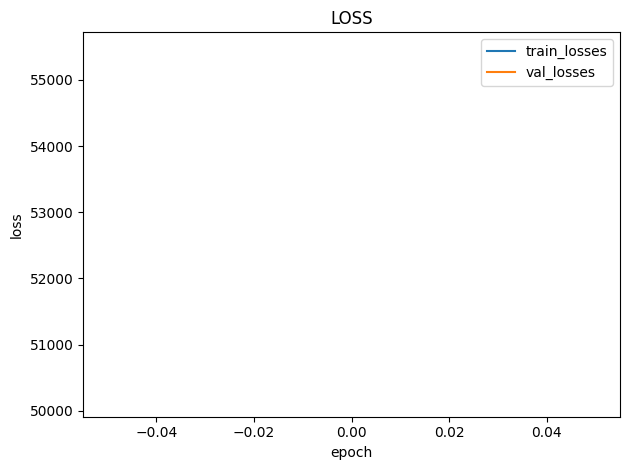

Epoch 0 [99|625] | Loss 36227.5623
36227.5623046875
[52813.3476953125, 36227.5623046875]


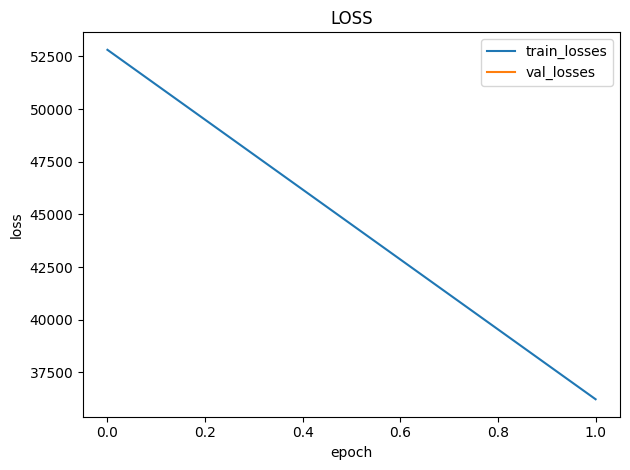

Epoch 0 [149|625] | Loss 28867.5917
28867.591702473957
[52813.3476953125, 36227.5623046875, 28867.591702473957]


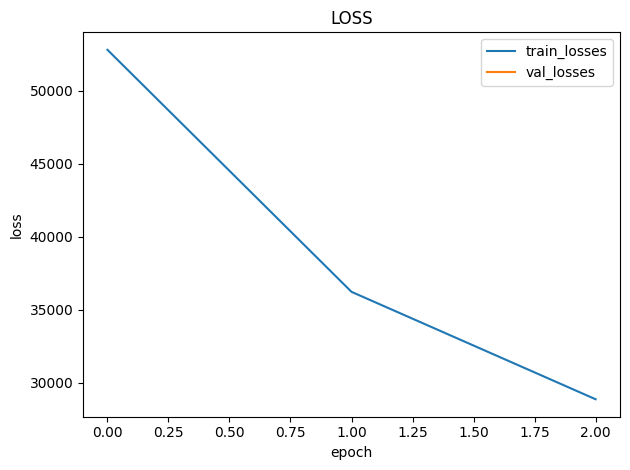

Epoch 0 [199|625] | Loss 24693.0688
24693.068774414063
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063]


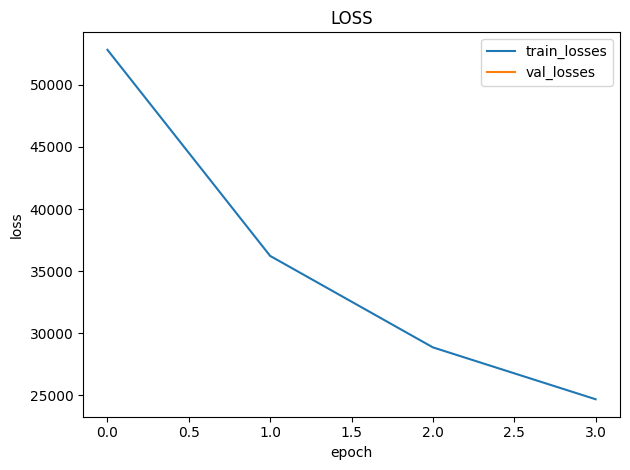

Epoch 0 [249|625] | Loss 22109.5580
22109.557982421877
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877]


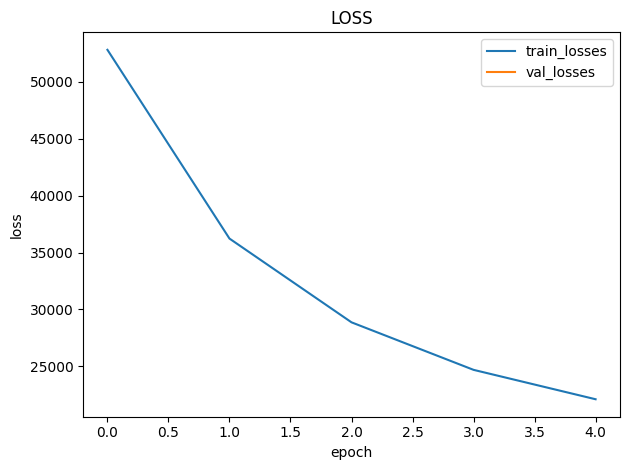

Epoch 0 [299|625] | Loss 19697.2611
19697.261131184896
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896]


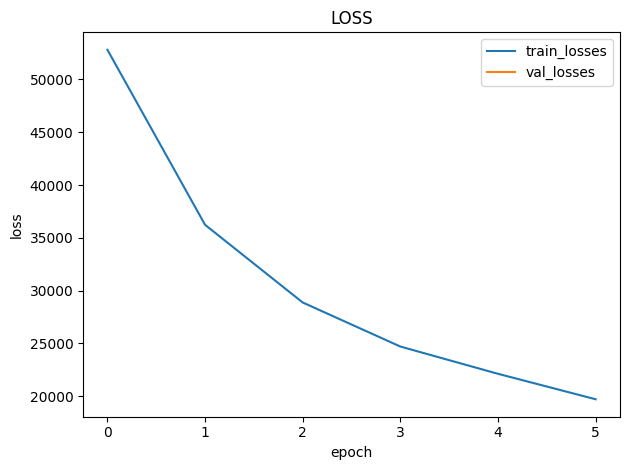

Epoch 0 [349|625] | Loss 17395.7695
17395.769493931362
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362]


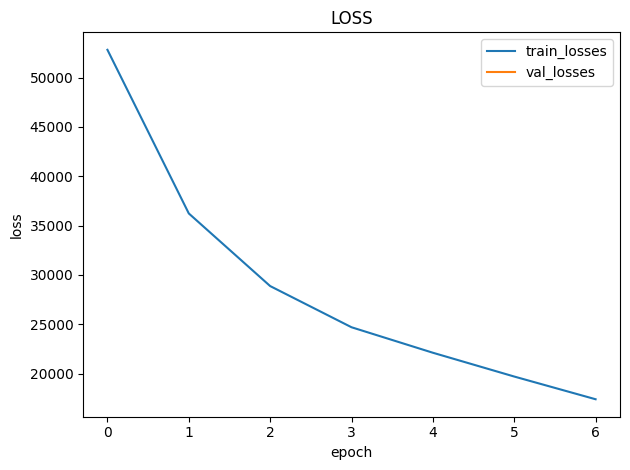

Epoch 0 [399|625] | Loss 15363.1345
15363.134485168457
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457]


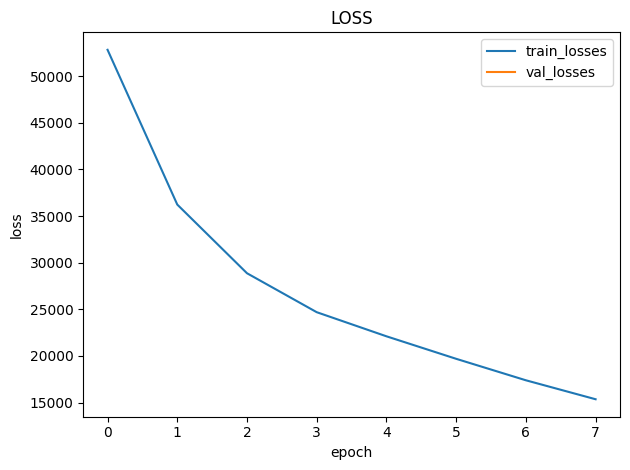

Epoch 0 [449|625] | Loss 13724.3041
13724.30405734592
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592]


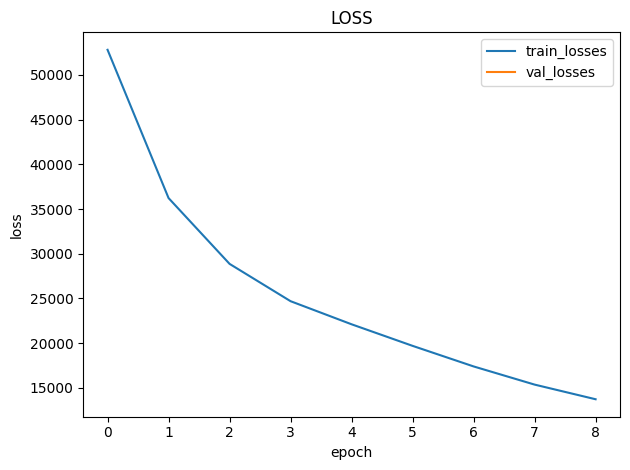

Epoch 0 [499|625] | Loss 12205.3572
12205.357213989259
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259]


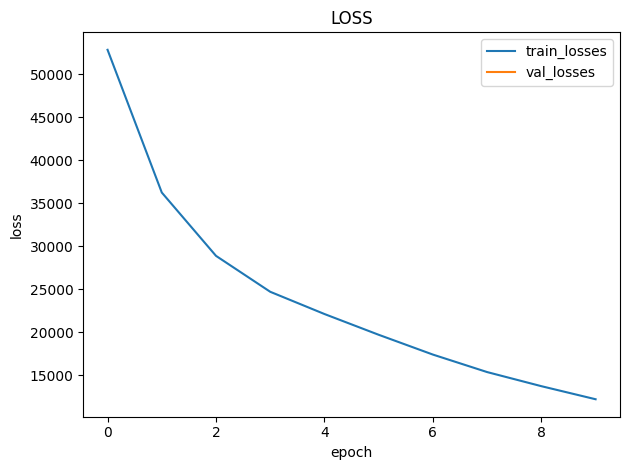

Epoch 0 [549|625] | Loss 10862.5932
10862.593226373845
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845]


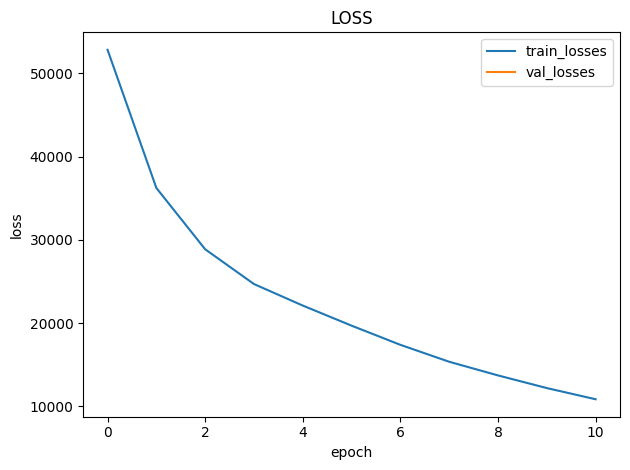

Epoch 0 [599|625] | Loss 9668.0523
9668.05231338501
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501]


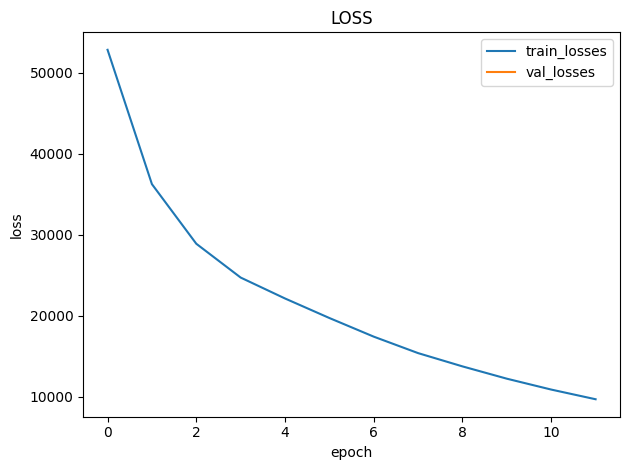

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/63 [00:00<?, ?it/s]

828.6615600585938
[828.6615600585938]
817.6143798828125
[828.6615600585938, 817.6143798828125]
750.4457397460938
[828.6615600585938, 817.6143798828125, 750.4457397460938]
755.3741455078125
[828.6615600585938, 817.6143798828125, 750.4457397460938, 755.3741455078125]
725.9882202148438
[828.6615600585938, 817.6143798828125, 750.4457397460938, 755.3741455078125, 725.9882202148438]
686.310791015625
[828.6615600585938, 817.6143798828125, 750.4457397460938, 755.3741455078125, 725.9882202148438, 686.310791015625]
706.1285400390625
[828.6615600585938, 817.6143798828125, 750.4457397460938, 755.3741455078125, 725.9882202148438, 686.310791015625, 706.1285400390625]
731.188720703125
[828.6615600585938, 817.6143798828125, 750.4457397460938, 755.3741455078125, 725.9882202148438, 686.310791015625, 706.1285400390625, 731.188720703125]
721.3411254882812
[828.6615600585938, 817.6143798828125, 750.4457397460938, 755.3741455078125, 725.9882202148438, 686.310791015625, 706.1285400390625, 731.188720703125, 7

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1 [49|625] | Loss -4431.3816
-4431.381553955078
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501, -4431.381553955078]


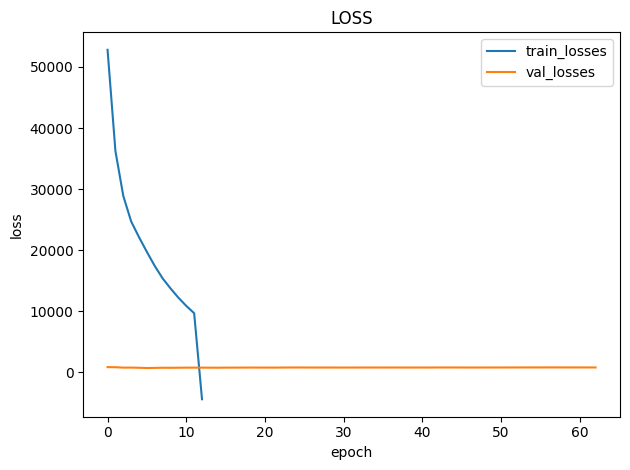

Epoch 1 [99|625] | Loss -4864.6764
-4864.676430053711
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501, -4431.381553955078, -4864.676430053711]


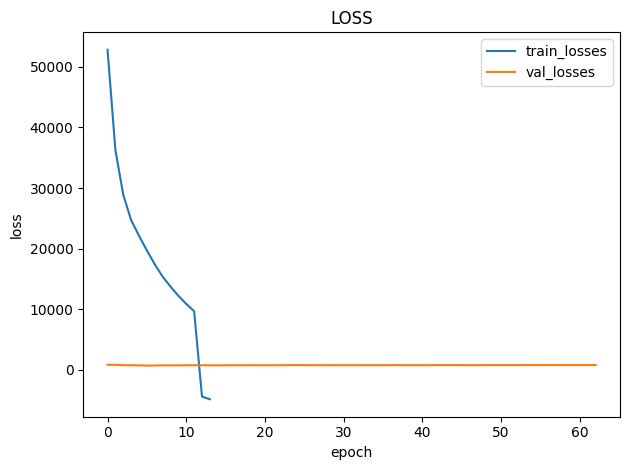

Epoch 1 [149|625] | Loss -5404.7301
-5404.730121663411
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501, -4431.381553955078, -4864.676430053711, -5404.730121663411]


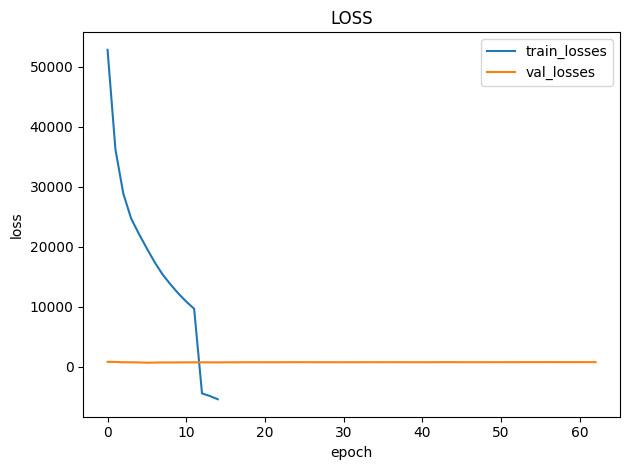

Epoch 1 [199|625] | Loss -5824.4017
-5824.401673278809
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501, -4431.381553955078, -4864.676430053711, -5404.730121663411, -5824.401673278809]


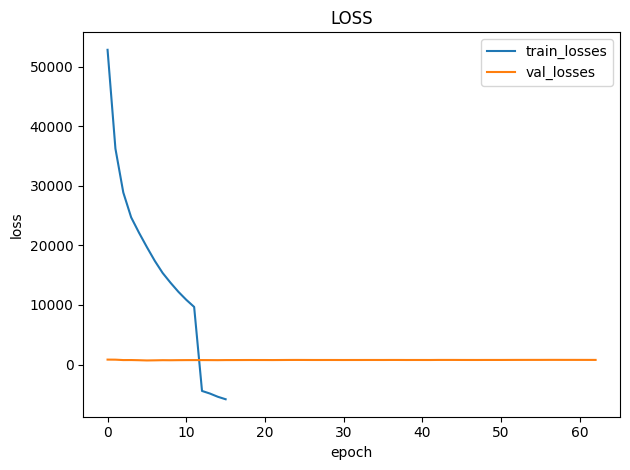

Epoch 1 [249|625] | Loss -6327.1203
-6327.120315185547
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501, -4431.381553955078, -4864.676430053711, -5404.730121663411, -5824.401673278809, -6327.120315185547]


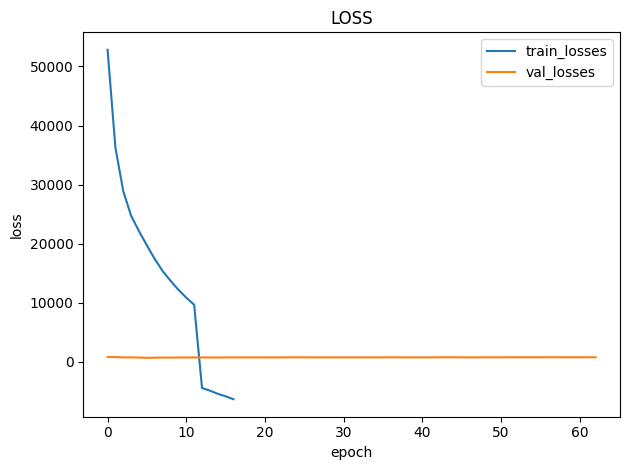

Epoch 1 [299|625] | Loss -6826.0052
-6826.005174763997
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501, -4431.381553955078, -4864.676430053711, -5404.730121663411, -5824.401673278809, -6327.120315185547, -6826.005174763997]


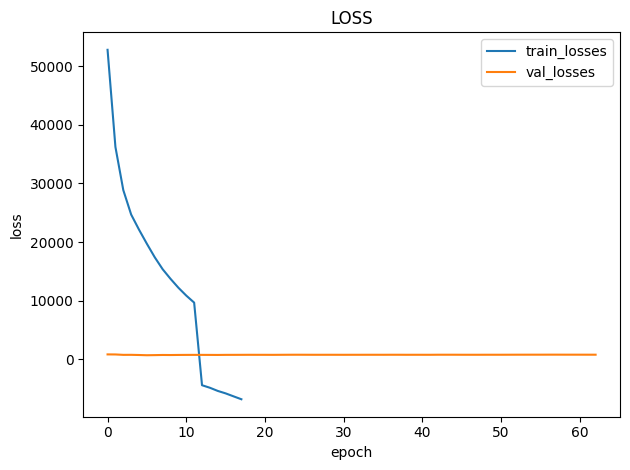

Epoch 1 [349|625] | Loss -7332.0036
-7332.003576136998
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501, -4431.381553955078, -4864.676430053711, -5404.730121663411, -5824.401673278809, -6327.120315185547, -6826.005174763997, -7332.003576136998]


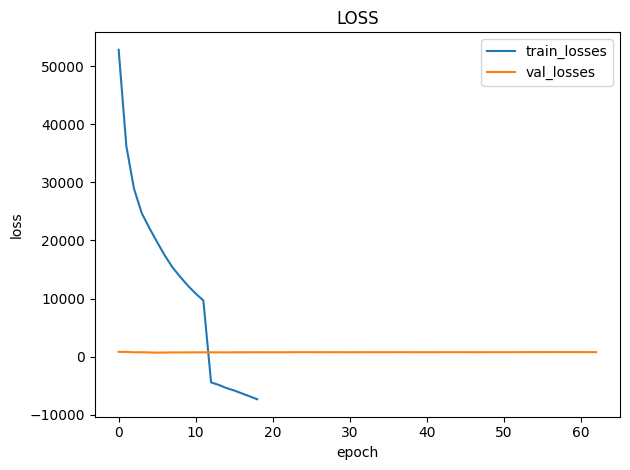

Epoch 1 [399|625] | Loss -7818.1069
-7818.106945037842
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501, -4431.381553955078, -4864.676430053711, -5404.730121663411, -5824.401673278809, -6327.120315185547, -6826.005174763997, -7332.003576136998, -7818.106945037842]


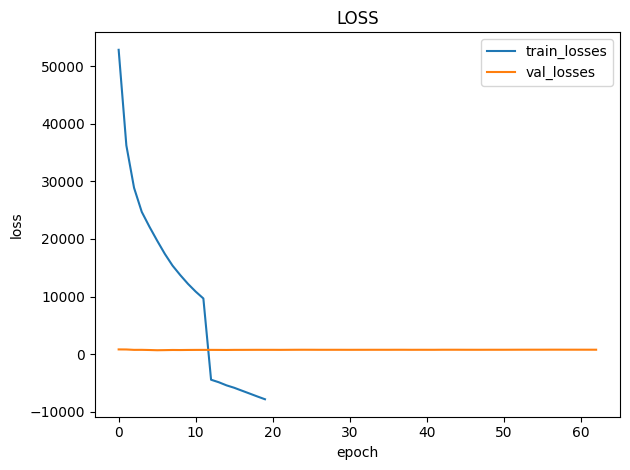

Epoch 1 [449|625] | Loss -8239.6622
-8239.662199842665
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501, -4431.381553955078, -4864.676430053711, -5404.730121663411, -5824.401673278809, -6327.120315185547, -6826.005174763997, -7332.003576136998, -7818.106945037842, -8239.662199842665]


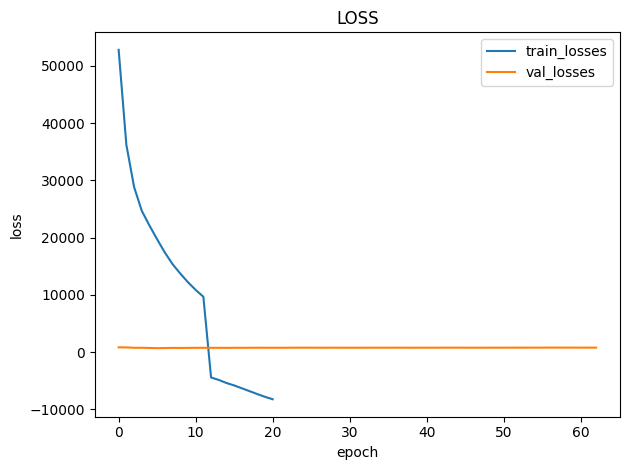

Epoch 1 [499|625] | Loss -8658.7167
-8658.716663452149
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501, -4431.381553955078, -4864.676430053711, -5404.730121663411, -5824.401673278809, -6327.120315185547, -6826.005174763997, -7332.003576136998, -7818.106945037842, -8239.662199842665, -8658.716663452149]


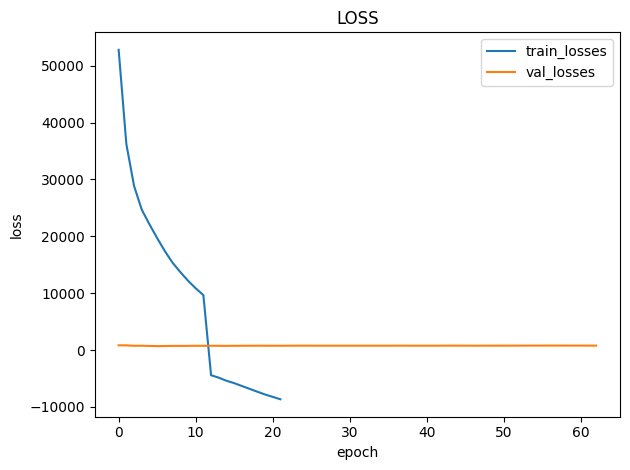

Epoch 1 [549|625] | Loss -9048.5510
-9048.550990212181
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501, -4431.381553955078, -4864.676430053711, -5404.730121663411, -5824.401673278809, -6327.120315185547, -6826.005174763997, -7332.003576136998, -7818.106945037842, -8239.662199842665, -8658.716663452149, -9048.550990212181]


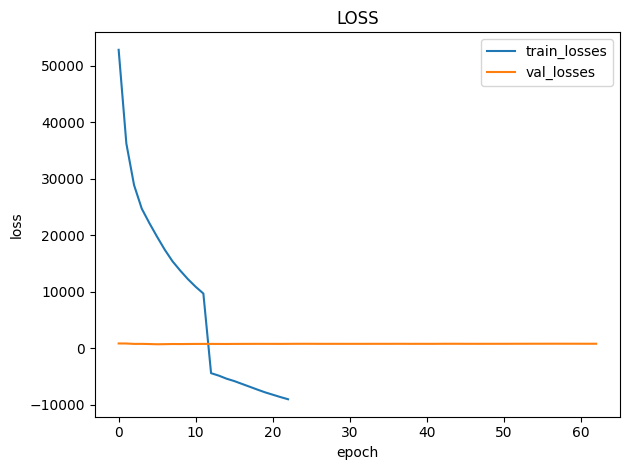

Epoch 1 [599|625] | Loss -9395.5071
-9395.507050272623
[52813.3476953125, 36227.5623046875, 28867.591702473957, 24693.068774414063, 22109.557982421877, 19697.261131184896, 17395.769493931362, 15363.134485168457, 13724.30405734592, 12205.357213989259, 10862.593226373845, 9668.05231338501, -4431.381553955078, -4864.676430053711, -5404.730121663411, -5824.401673278809, -6327.120315185547, -6826.005174763997, -7332.003576136998, -7818.106945037842, -8239.662199842665, -8658.716663452149, -9048.550990212181, -9395.507050272623]


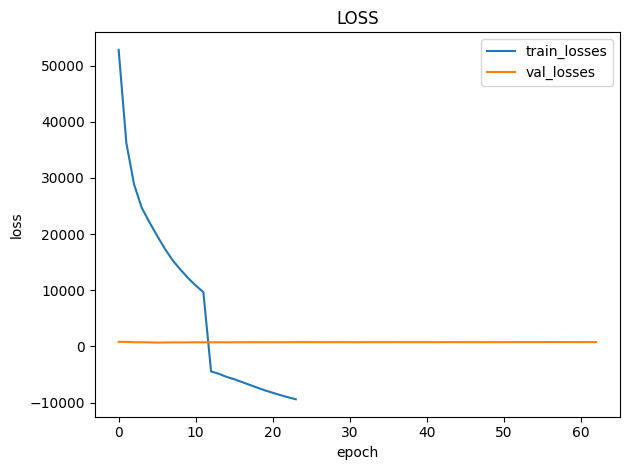

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/63 [00:00<?, ?it/s]

575.7505493164062
[828.6615600585938, 817.6143798828125, 750.4457397460938, 755.3741455078125, 725.9882202148438, 686.310791015625, 706.1285400390625, 731.188720703125, 721.3411254882812, 735.6761474609375, 743.8707275390625, 747.80810546875, 746.8677368164062, 741.9881591796875, 734.98291015625, 748.933349609375, 751.1978149414062, 755.2545776367188, 760.1426391601562, 757.4415893554688, 757.6515502929688, 752.3449096679688, 760.1239013671875, 767.8629150390625, 771.7706298828125, 768.5040893554688, 763.32470703125, 762.6193237304688, 763.99560546875, 762.82470703125, 760.122314453125, 762.819091796875, 763.0628051757812, 765.5023803710938, 765.5133666992188, 763.8533325195312, 768.6033325195312, 768.1913452148438, 762.0093383789062, 764.7124633789062, 763.734130859375, 762.4038696289062, 772.9998168945312, 773.216552734375, 772.5079345703125, 767.8794555664062, 766.4116821289062, 765.62158203125, 769.437255859375, 769.7644653320312, 769.4680786132812, 773.1369018554688, 776.914794921

In [14]:
# モデルの構築
model = build_vimon(config)

# Trainerの初期化
trainer = Trainer(config, model, [train_loader, val_loader])

# 以前のチェックポイントの読み込み
# checkpoint_file = '/content/drive/MyDrive/世界モデル/最終課題/Check/ckpt_vimon_best.pt'
# checkpoint = torch.load(os.path.join(trainer.ckpt_dir, checkpoint_file))

# # モデルの重みを読み込み
# model.load_state_dict(checkpoint['model_state_dict'])

# # Optimizerの状態を読み込み
# trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # 以前のエポック数を引き継ぐ
# trainer.start_epoch = checkpoint['epoch'] + 1

# 新しいOptimizerを作成する場合（例：学習率を変更したい場合）
# trainer.optimizer = optim.AdamW(model.parameters(), lr=new_learning_rate)

# 再学習を行う
print('Start training.')
trainer.train()
print('Done.')


## 結果

In [16]:
save_path = '/content/drive/MyDrive/世界モデル/最終課題/LOSS/'
# データを読み込む
with open(os.path.join(save_path, f'train_losses_all_epochs.pkl'), 'rb') as f:
    loaded_train_losses = pickle.load(f)

with open(os.path.join(save_path, f'train_losses_all_epochs_2.pkl'), 'rb') as f:
    loaded_train_losses_2 = pickle.load(f)

with open(os.path.join(save_path, f'train_losses_all_epochs_3.pkl'), 'rb') as f:
    loaded_train_losses_3 = pickle.load(f)

with open(os.path.join(save_path, f'train_losses_all_epochs_4.pkl'), 'rb') as f:
    loaded_train_losses_4 = pickle.load(f)
print(loaded_train_losses)
print(loaded_train_losses_2)
print(loaded_train_losses_3)
print(loaded_train_losses_4)

    Epoch    Train_Loss
0       1  99457.002695
1       2  55695.274219
2       3  39049.404814
3       4  30010.916627
4       5  24190.893134
5       6  19882.361884
6       7  16629.382346
7       8  14072.507218
8       9  12001.134084
9      10  10266.272843
10     11   8791.699812
11     12   7553.351172
12     13  -6834.440166
13     14  -7249.705386
14     15  -7782.135498
15     16  -8171.639976
16     17  -8567.166986
17     18  -9019.521414
18     19  -9426.117158
19     20  -9741.897026
20     21 -10057.800833
21     22 -10339.034492
22     23 -10607.763766
23     24 -10855.059593
    Epoch    Train_Loss
0       1  69944.932461
1       2  44281.870186
2       3  34114.463633
3       4  27540.151473
4       5  22531.800809
5       6  18682.128767
6       7  15663.494749
7       8  13219.390591
8       9  11317.786786
9      10   9782.259983
10     11   8491.472840
11     12   7401.262084
12     13  -5860.871270
13     14  -6096.604731
14     15  -6698.848494
15     16  -7409

In [17]:
save_path = '/content/drive/MyDrive/世界モデル/最終課題/LOSS/'
# データを読み込む
with open(os.path.join(save_path, f'val_losses_all_epochs.pkl'), 'rb') as f:
    loaded_val_losses = pickle.load(f)

with open(os.path.join(save_path, f'val_losses_all_epochs_2.pkl'), 'rb') as f:
    loaded_val_losses_2 = pickle.load(f)

with open(os.path.join(save_path, f'val_losses_all_epochs_3.pkl'), 'rb') as f:
    loaded_val_losses_3 = pickle.load(f)

with open(os.path.join(save_path, f'val_losses_all_epochs_4.pkl'), 'rb') as f:
    loaded_val_losses_4 = pickle.load(f)
print(loaded_val_losses)
print(loaded_val_losses_2)
print(loaded_val_losses_3)
print(loaded_val_losses_4)

     Epoch    val_Loss
0        1  783.823242
1        2  791.700562
2        3  721.788940
3        4  723.439209
4        5  698.583862
..     ...         ...
121    122  509.310272
122    123  507.748779
123    124  508.166321
124    125  507.689056
125    126  506.631805

[126 rows x 2 columns]
     Epoch    val_Loss
0        1  799.749084
1        2  798.067871
2        3  729.435425
3        4  729.071350
4        5  700.225708
..     ...         ...
121    122  458.409088
122    123  457.408051
123    124  458.349976
124    125  457.883911
125    126  457.011719

[126 rows x 2 columns]
     Epoch    val_Loss
0        1  828.661560
1        2  817.614380
2        3  750.445740
3        4  755.374146
4        5  725.988220
..     ...         ...
121    122  497.137329
122    123  497.031952
123    124  495.766998
124    125  495.642578
125    126  494.898285

[126 rows x 2 columns]
     Epoch    val_Loss
0        1  919.909180
1        2  883.401367
2        3  790.542358
3       

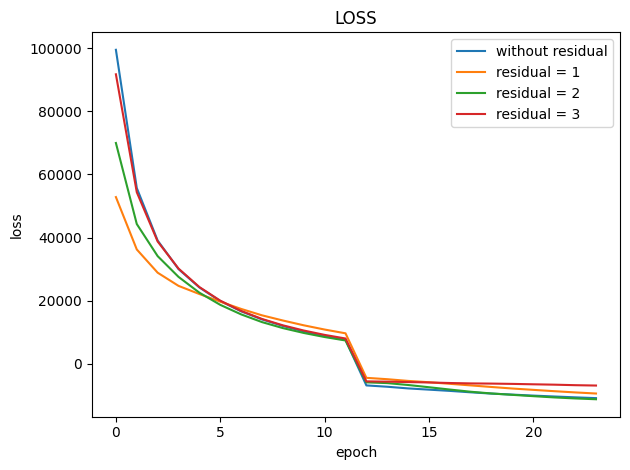

In [18]:
plt.plot(loaded_train_losses["Train_Loss"], label='without residual')
plt.plot(loaded_train_losses_3["Train_Loss"], label='residual = 1')
plt.plot(loaded_train_losses_2["Train_Loss"], label='residual = 2')
plt.plot(loaded_train_losses_4["Train_Loss"], label='residual = 3')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/世界モデル/最終課題/train_comp_plot.png')
plt.show()
plt.close()

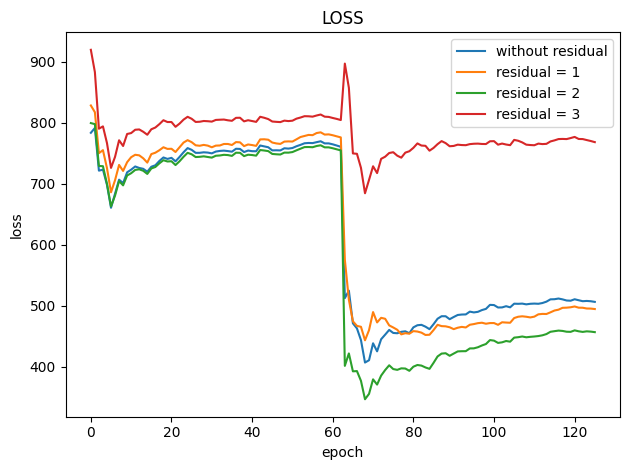

In [19]:
plt.plot(loaded_val_losses["val_Loss"], label='without residual')
plt.plot(loaded_val_losses_3["val_Loss"], label='residual = 1')
plt.plot(loaded_val_losses_2["val_Loss"], label='residual = 2')
plt.plot(loaded_val_losses_4["val_Loss"], label='residual = 3')
plt.title('LOSS')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/世界モデル/最終課題/val_comp_plot.png')
plt.show()
plt.close()

In [ ]:
loaded_train_losses

,Epoch,Train_Loss
0,1,99457.002695
1,2,55695.274219
2,3,39049.404814
3,4,30010.916627
4,5,24190.893134
5,6,19882.361884
6,7,16629.382346
7,8,14072.507218
8,9,12001.134084
9,10,10266.272843
